In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import math
import matplotlib.pyplot as plt
import numpy as np


In [2]:
import aaa.attention as attention
import aaa.train_attention as train_attention


['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content']


## Here is the design of the Attack-Adaptive Aggregation model

In [3]:
hidden_size=21
n_input=10
net=attention.AttentionLoop(n_input,hidden_size ,bias=False, nloop=5, eps=0.05, scale=10)

## Dataset preparation

A synthetic dataset. Each sample is a set of n data points, each with k dimensions. The outlier differ from the inlier in the first 1/3 dimension. While the remaining dimensions have the same mean but different variances. The last 1/3 dimension has a large variance.

In [4]:
from sklearn.datasets import make_blobs

# mixture of multinormal, only the first 1/3 dimension can have distinct mean, the last 1/3 dimension has larger variance
def genCluster(n=10,k=10000,frac=0.8,std=0.5,scale=1):
  # Starts from 2 clusters with distinct mean
  X, Y = make_blobs(n_samples=[int(n*frac),n-int(n*frac)], n_features=k,cluster_std=std*scale, center_box=(-scale*10,scale*10))

  # Make the last 2/3 dimension to have the same mean
  n_cohe=int(k*2.0/3.0)
  coherent,_=make_blobs(n_samples=[n], n_features=n_cohe,cluster_std=std*scale, center_box=(-scale*10,scale*10) )

  # Make the last 1/3 dimension to have the same mean but larger variance
  n_cohe_noisy=int(k/3.0)
  std=std*40
  coherent_noisy,_=make_blobs(n_samples=[n], n_features=n_cohe_noisy,cluster_std=std*scale, center_box=(-scale*10,scale*10) )
  
  X[:,k-n_cohe:]=coherent
  X[:,k-n_cohe_noisy:]=coherent_noisy


  x=torch.Tensor(X).permute(1,0) # sets of data
  y=1-torch.Tensor(Y).expand(k,n) # ground truth: 1 is the smaller cluster (act as outlier), 0 is the larger cluster (inlier)
  center=((x*y).sum(-1)/y.sum(-1)) 
  c=center.expand(n,k).permute(1,0) # robust mean of the data

  y_=y[0,:].unsqueeze(0)
  return x,y,c

In [5]:
from torch.utils.data import Dataset, DataLoader
class cluster(Dataset):
    '''
    Adapter to convert the sklearn dataset to a pytorch dataset
    
    size: number of sets of sample to be generated
    n: number of data in each sample
    k: the number of feature/ dimension of each data 
    randX: whether generate sample with random X
    '''
    def __init__(self, size,n=10,k=10000,randN=False, randStd=False, randScale=False):
        self.size=size
        self.n=n
        self.k=k
        self.randN=randN
        self.randStd=randStd
        self.randScale=randScale
        self.samples=[]
        # generate samples
        for i in range(size):
          sample =self.generateData()
          self.samples.append(sample)

    def generateData(self):
        std=0.5
        scale=1.0
        frac=0.8
        if self.randN:
          frac=torch.rand(1).item()*0.4+0.6 #0.6-1.0
        if self.randStd:
          std=(torch.rand(1).item()*2-1)*0.4+0.5 #0.3-0.7
        if self.randScale:
          scale=10.0**((torch.rand(1).item()*2-1)*4) #1e-4 to 1e+4
        sample =genCluster(n=self.n,k=self.k,frac=frac,std=std,scale=scale)
        return sample


    def __len__(self):
        return self.size

    def __getitem__(self, idx):
       
        sample=self.samples[idx]
        return sample


In [6]:
# Dataloader
n=10
k=30
B=2048
b=64
print(f'num inputs: {n} | input dimension: {k} | Batchsize: {b} | passes of minibatch sgd in each epoch: {B/b:.0f}')

dataloader = DataLoader(cluster(B,n,k,randN=False), batch_size=b)
validloader = DataLoader(cluster(B//4,n,k,randN=False), batch_size=b)
testloader = DataLoader(cluster(B//4,n,k,randN=True), batch_size=b)
testloader1 = DataLoader(cluster(B//4,n,k,randStd=True), batch_size=b)
testloader2 = DataLoader(cluster(B//4,n,k,randScale=True), batch_size=b)

num inputs: 10 | input dimension: 30 | Batchsize: 64 | passes of minibatch sgd in each epoch: 32


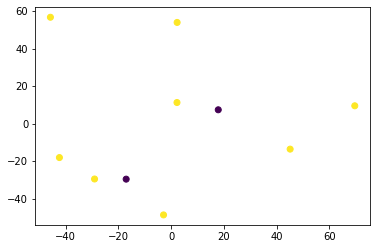

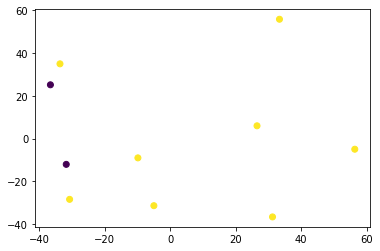

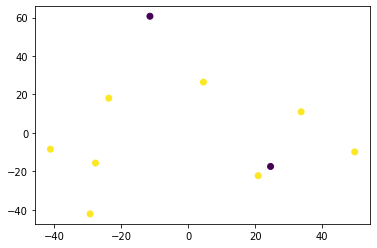

In [7]:
# visualize some samples in PCA
demoDset=cluster(B,n,k)
from sklearn.decomposition import PCA
for i in range(3):
  x,y,c=demoDset[i]


  pca = PCA(n_components=2, random_state=0)
  x_proj= pca.fit_transform(x.permute(1,0))
  plt.figure()
  plt.scatter(x_proj[:,0],x_proj[:,1],c=y[0,:])


## Helper function for plotting a set of data points

In [8]:
def plot(x,ax=None,**kwargs):
  if ax!=None:
    return ax.imshow(x.cpu().detach()[0,:,:].permute(1,0),**kwargs)
  else:
    return plt.imshow(x.cpu().detach()[0,:,:].permute(1,0),**kwargs)

## Visulization before training

[]

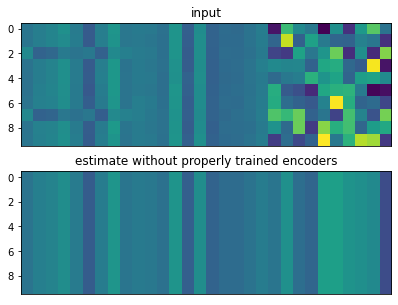

In [9]:
hidden_size=2
x = cluster(B,n,k)[0][0].unsqueeze(0)
beta=x[:,:,0:1] #select the first data point to be the query
net = attention.AttentionLoop(k, hidden_size, nloop=5, eps=0.5/n, scale=10)
out=net(beta,x)
aff=net.getWeight(beta,x)

fig, axs = plt.subplots(2, 1,figsize=(15,5))
plot(x,axs[0])
axs[0].set_title('input')
vmin,vmax=axs[0].get_images()[0].get_clim()
plot(out.repeat(1,1,n),axs[1], vmin=vmin,vmax=vmax)
axs[1].set_title('estimate without properly trained encoders')
axs[0].set_xticks([])
axs[1].set_xticks([])

Text(0.5, 1.0, 'Affinity matrix')

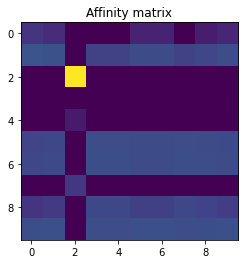

In [10]:
plot(net.getWeight(x,x))
plt.title('Affinity matrix')

## Helper functions/classes

In [11]:
# getting hard prediction
getBinaryPred=train_attention.getBinaryPred

# helper class to record the accumulating loss
# +=: add loss
# print(**): print the average loss
loss_acc=train_attention.loss_acc

# metrics
test=train_attention.test # l1 loss
test_classes=train_attention.test_classes # accuracy

## Training settings

In [12]:
epochs=200
hidden_size=21
learning_rate=1e-4

model = attention.AttentionLoop(k, hidden_size, nloop=5, eps =0.5/n, scale=10)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn=train_attention.loss_fn=torch.nn.L1Loss(reduction='mean')

## start training!

In [13]:
print(f'      {"train loss"}|{"train loss(b)"}|{"valid loss"}|{"valid loss(b)"}|\
 {"test loss"}| {"test loss(b)"}|  {"L1~median"}| {"L1~mean"} \
||{"train accuracy"}| {"valid accuracy"}| {"test accuracy"}\t {"test1 loss"}|\
{"test1 loss(b)"}|{"test1 accuracy"} \t {"test2 loss"}|{"test2 loss(b)"}|{"test2 accuracy"}')
train_loss=[]
train_loss_hard=[]
valid_loss=[]
valid_loss_hard=[]
test_loss=[]
test_loss_hard=[]
train_acc=[]
valid_acc=[]
test_acc=[]
for i in range(epochs):
  lossCounter=loss_acc()
  lossCounter2=loss_acc()
  lossCounter_median_ref=loss_acc()
  lossCounter_mean_ref=loss_acc()

  for x,y,c in dataloader:
    optimizer.zero_grad()
    x=x.cuda()
    y=y.cuda()
    c=c.cuda()
    beta=x.median(dim=-1,keepdims=True)[0]
    beta1=x.mean(dim=-1,keepdims=True)

    # loss=loss_fn(model.cuda()(x),y[:,[0],:])
    # loss=loss_fn(model.cuda()(x,x),z)
    pred=model.cuda()(beta1,x)
    loss=loss_fn(pred,c[:,:,[0]])

    pred_b=getBinaryPred(model,x,beta1)
    loss_b=loss_fn(pred_b,c[:,:,[0]])
    
    lossCounter+=loss.cpu().detach().numpy()
    lossCounter2+=loss_b.cpu().detach().numpy()

    loss_median_ref=loss_fn(beta,c[:,:,[0]])
    loss_mean_ref=loss_fn(beta1,c[:,:,[0]])

    lossCounter_median_ref+=loss_median_ref.cpu().detach().numpy()
    lossCounter_mean_ref+=loss_mean_ref.cpu().detach().numpy()
    # print(f'{loss:.4f},{loss_b:.6f}')

    loss.backward()
    optimizer.step()
  # print(f'train: {lossCounter},{lossCounter2}')


  lossCounter_valid, lossCounter2_valid=test(model,validloader)
  lossCounter_test, lossCounter2_test=test(model,testloader)
  lossCounter_test1, lossCounter2_test1=test(model,testloader1)
  lossCounter_test2, lossCounter2_test2=test(model,testloader2)

  train_score=test_classes(model.cpu(),dataloader)
  valid_score=test_classes(model.cpu(),validloader)
  test_score=test_classes(model.cpu(),testloader)
  test_score1=test_classes(model.cpu(),testloader1)
  test_score2=test_classes(model.cpu(),testloader2)


  print(f'{i}\t{lossCounter}|   {lossCounter2}  | {lossCounter_valid} |   \
{lossCounter2_valid}  | {lossCounter_test} |   {lossCounter2_test}  |  \
{lossCounter_median_ref} | {lossCounter_mean_ref}\
||   {train_score:.6f}   |    {valid_score:.6f}   | {test_score:.6f}\t  {lossCounter_test1} |   { lossCounter2_test1}  |{test_score1:.6f} \t\t {lossCounter_test2} |  { lossCounter2_test2}  |   {test_score2:.6f}')
  # print()
  train_loss.append(lossCounter.value())
  train_loss_hard.append(lossCounter2.value())
  valid_loss.append(lossCounter_valid.value())
  valid_loss_hard.append(lossCounter2_valid.value())
  test_loss.append(lossCounter_test.value())
  test_loss_hard.append(lossCounter2_test.value())

  train_acc.append(train_score)
  valid_acc.append(valid_score)
  test_acc.append(test_score)


      train loss|train loss(b)|valid loss|valid loss(b)| test loss| test loss(b)|  L1~median| L1~mean ||train accuracy| valid accuracy| test accuracy	 test1 loss|test1 loss(b)|test1 accuracy 	 test2 loss|test2 loss(b)|test2 accuracy
0	4.362111|   4.644435  | 4.234603 |   4.506513  | 4.409036 |   4.670899  |  1.692740 | 1.312165||   0.000000   |    0.000000   | 0.000000	  4.309470 |   4.546963  |0.009766 		 2466.660126 |  2650.844727  |   0.000000
1	4.289779|   4.576537  | 4.167753 |   4.444899  | 4.354357 |   4.631085  |  1.692740 | 1.312165||   0.000000   |    0.000000   | 0.000000	  4.269637 |   4.517402  |0.009766 		 2437.094025 |  2609.393661  |   0.000000
2	4.235992|   4.521748  | 4.114908 |   4.397942  | 4.292902 |   4.576388  |  1.692740 | 1.312165||   0.000000   |    0.000000   | 0.000000	  4.210989 |   4.459444  |0.009766 		 2403.911514 |  2581.419495  |   0.000000
3	4.183736|   4.472765  | 4.062456 |   4.345271  | 4.248347 |   4.528708  |  1.692740 | 1.312165||   0.000000   |

199


Text(0.5, 1.0, 'accuracy (from hard prediction)')

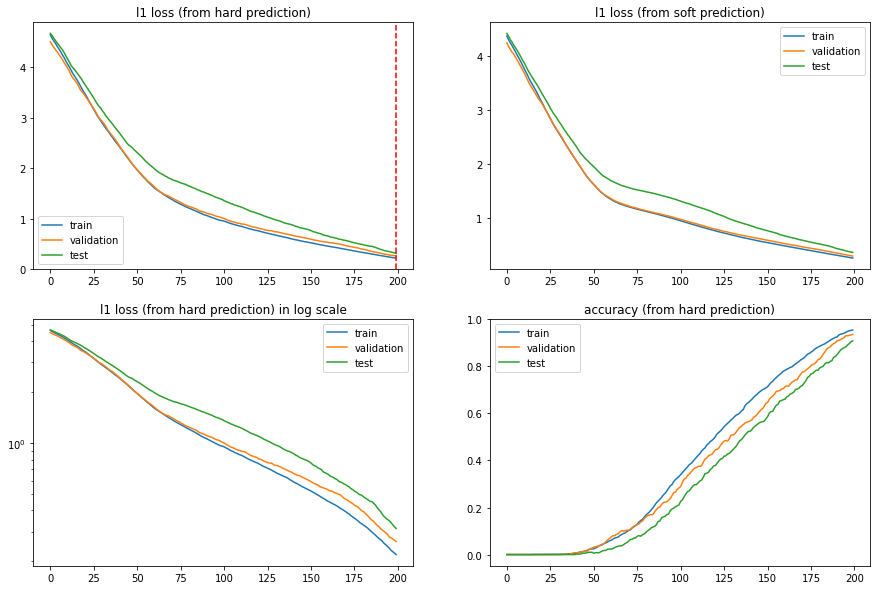

In [14]:
fig,ax=plt.subplots(2,2,figsize=(15,10))

ax[0,0].plot(train_loss_hard)
ax[0,0].plot(valid_loss_hard)
ax[0,0].plot(test_loss_hard)
ax[0,0].legend(['train','validation','test'])
ax[0,0].set_title("l1 loss (from hard prediction)")
earlyStop=np.argmin(valid_loss_hard)
print(earlyStop)
ax[0,0].axvline(earlyStop,c='r',linestyle='dashed')
# ax[0,0].set_yscale('log')


ax[1,0].plot(train_loss_hard)
ax[1,0].plot(valid_loss_hard)
ax[1,0].plot(test_loss_hard)
ax[1,0].set_yscale('log')
ax[1,0].legend(['train','validation','test'])
ax[1,0].set_title("l1 loss (from hard prediction) in log scale")

ax[0,1].plot(train_loss)
ax[0,1].plot(valid_loss)
ax[0,1].plot(test_loss)
ax[0,1].legend(['train','validation','test'])
ax[0,1].set_title("l1 loss (from soft prediction)")

ax[1,1].plot(train_acc)
ax[1,1].plot(valid_acc)
ax[1,1].plot(test_acc)
ax[1,1].legend(['train','validation','test'])
ax[1,1].set_title("accuracy (from hard prediction)")



## Visualize the results

In [15]:
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
from matplotlib import rcParams
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['legend.fontsize'] = 9
import matplotlib.pyplot as plt

import numpy as np
WIDTH = 487.0  # the number latex spits out
FACTOR = 0.5  # the fraction of the width you'd like the figure to occupy
figwidthpt  = WIDTH * FACTOR

inchesperpt = 1.0 / 72.27
golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good

figwidthin  = figwidthpt * inchesperpt  # figure width in inches
figheightin = figwidthin * golden_ratio   # figure height in inches
fig_dims    = [figwidthin, figheightin] # fig dims as a list

In [16]:
itr=iter(testloader)

             aggregator: L1 loss
                     gt: 0.0
                   mean: 1.3606404066085815
                 median: 0.7674960494041443
pred (init with median): 0.3518734574317932
 pred2 (init with mean): 0.3533848822116852
       pred hard/binary: 0.3192252516746521



<Figure size 432x288 with 0 Axes>

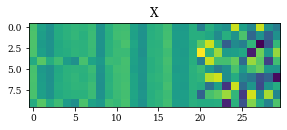

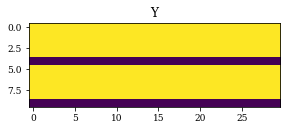

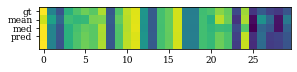

[]

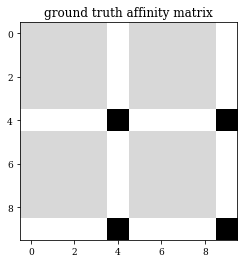

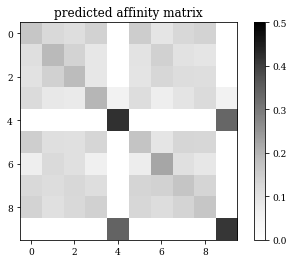

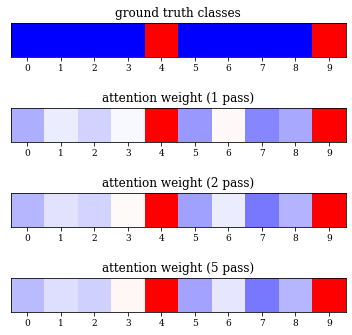

In [17]:
plt.set_cmap('viridis')

x,y,c=next(itr)
x=x[[0],:,:]
y=y[[0],:,:]
c=c[[0],:,:]


figsize=(x.shape[1]/200*30,5)

plt.figure(figsize=figsize)
plot(x)
plt.title('X')
plt.figure(figsize=figsize)
plot(y)
plt.title('Y')


gt=c[:,:,[0]]

med=x.median(dim=-1,keepdims=True)[0]
mean=x.mean(dim=-1,keepdims=True)

beta=med

pred=model.cpu()(beta,x)
beta1=mean

pred2=model.cpu()(beta1,x)

predB=getBinaryPred(model,x,beta)

plt.figure(figsize=(x.shape[1]/200*30,5))
plot(torch.cat((gt,mean,med,pred,predB),-1))
plt.yticks([0,1,2,3],['gt','mean','med','pred','pred binary'])


print(f'\
             aggregator: L1 loss\n\
                     gt: {loss_fn(gt,gt)}\n\
                   mean: {loss_fn(mean,gt)}\n\
                 median: {loss_fn(med,gt)}\n\
pred (init with median): {loss_fn(pred,gt)}\n\
 pred2 (init with mean): {loss_fn(pred2,gt)}\n\
       pred hard/binary: {loss_fn(predB,gt)}\n')

plt.show()

# plt.set_cmap('bwr_r')

plt.set_cmap('Greys')

# x,y,c,z=next(iter(dataloader))
# beta=x.median(dim=-1,keepdims=True)[0]
Y=y[:,[0],:]
truth=torch.bmm(Y.permute(0,2,1),Y)+torch.bmm((1-Y).permute(0,2,1),1-Y)
truth=F.normalize(truth,p=1,dim=1)
plot(truth,vmin=0,vmax=0.5)
plt.title("ground truth affinity matrix")

out=model.cpu().attention.affinity(x,x)
plt.figure()
plot(out,vmin=0,vmax=0.5)
plt.title("predicted affinity matrix")

plt.colorbar()


fig, axes=plt.subplots(4,1,figsize=(6,6))
plt.set_cmap('bwr_r')

plot(y[:,[0],:].permute(0,2,1),ax=axes[0],vmin=0,vmax=0.2)
axes[0].set_title("ground truth classes")
axes[0].set_xticks(range(10))
axes[0].set_yticks([])



plot(model.attention.affinity(beta,x).permute(0,2,1),ax=axes[1],vmin=0,vmax=0.2)
axes[1].set_title("attention weight (1 pass)")
axes[1].set_xticks(range(10))
axes[1].set_yticks([])

plot(model.attention.affinity(model.attention(beta,x)[0],x).permute(0,2,1),ax=axes[2],vmin=0,vmax=0.2)
axes[2].set_title("attention weight (2 pass)")
axes[2].set_xticks(range(10))
axes[2].set_yticks([])

plot(model.getWeight(beta,x).permute(0,2,1),ax=axes[3],vmin=0,vmax=0.2)
axes[3].set_title("attention weight (5 pass)")
axes[3].set_xticks(range(10))
axes[3].set_yticks([])


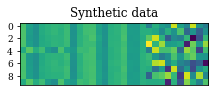

In [18]:
colors=np.array(['r','b'])

fig,ax=plt.subplots(1,1, figsize=[fig_dims[0],fig_dims[1]])
plt.set_cmap('viridis')

plot(x,ax)
ax.set_xticks([])
ax.set_yticks(range(0,10,2))
ax.set_title('Synthetic data')
plt.subplots_adjust(wspace=0.3)

plt.savefig('example.pdf',format='pdf',bbox_inches="tight")



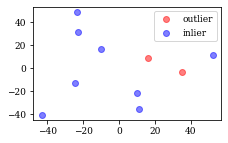

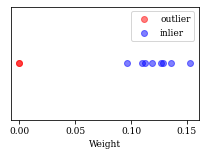

In [19]:
fig,ax=plt.subplots(1,1, figsize=[fig_dims[0],fig_dims[1]])

plt.set_cmap('viridis')

pca = PCA(n_components=2, random_state=0)
x_proj= pca.fit_transform(x[0,:,:].permute(1,0))
ax.scatter(x_proj[(y[0,0,:]==0).numpy(),0],x_proj[(y[0,0,:]==0).numpy(),1],c='r',alpha=0.5)
ax.scatter(x_proj[(y[0,0,:]==1).numpy(),0],x_proj[(y[0,0,:]==1).numpy(),1],c='b',alpha=0.5)

# ax.set_title('PCA on synthetic data')
ax.legend(['outlier','inlier'])

plt.savefig('exampleAnalysisPCA.pdf',format='pdf',bbox_inches="tight")

fig,ax=plt.subplots(1,1, figsize=[fig_dims[0],fig_dims[1]])

beta=x.median(dim=-1,keepdims=True)[0]
X=model.getWeight(beta,x).permute(0,2,1).detach().numpy()[0,:,0]
Y=np.array([0]*10)
ax.scatter(X[(y[0,0,:]==0).numpy()],Y[(y[0,0,:]==0).numpy()],c='r',alpha=0.5)
ax.scatter(X[(y[0,0,:]==1).numpy()],Y[(y[0,0,:]==1).numpy()],c='b',alpha=0.5)

ax.set_yticks([])
ax.set_xlabel('Weight')
# ax.set_title('Our model on synthetic data')
ax.legend(['outlier','inlier'])
# ax[1].set_

plt.subplots_adjust(wspace=0.3)

plt.savefig('exampleAnalysisOurs.pdf',format='pdf',bbox_inches="tight")


## Let's see how the value encoder looks like

In [20]:
model.cpu()

AttentionLoop(
  (attention): AttentionConv(
    (affinity): Affinity(
      (key_conv): nonLinearity(
        (main): Sequential(
          (0): Conv1d(30, 60, kernel_size=(1,), stride=(1,), bias=False)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv1d(60, 21, kernel_size=(1,), stride=(1,), bias=False)
        )
      )
      (query_conv): nonLinearity(
        (main): Sequential(
          (0): Conv1d(30, 60, kernel_size=(1,), stride=(1,), bias=False)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv1d(60, 21, kernel_size=(1,), stride=(1,), bias=False)
        )
      )
      (Threshold): Threshold(threshold=0.05, value=0)
    )
  )
)

In [21]:
weight0=model.attention.affinity.key_conv.main[0].state_dict()['weight']
weight1=model.attention.affinity.key_conv.main[2].state_dict()['weight']

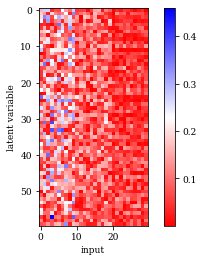

In [22]:
# visualize the weight
plt.imshow(weight0.squeeze().abs())
plt.xlabel("input")
plt.ylabel("latent variable")
plt.colorbar()
plt.set_cmap('bwr_r')


Let's try to visualize the importance of each input

define importance of weight \\[\mathrm{imptz}(w_{ij}):=\frac{|w_{ij}|}{\sum_{\hat{i}} |w_{{\hat{i}}j}|},\\] the contribution of an input node $i$ to an output node $j$

Then the contribution of an input node `i` can be estimated with \\[\mathrm{contri}(i)=\sum_j \mathrm{imptz}(w_{ij})\\]



In [23]:
def estimateImportance(weight):
  '''
  weight: assumes shape (w,h,1)
  '''

  # the contribution of input to each output
  imptz=torch.softmax(weight.squeeze().abs().log(),dim=1)
  # the approximated contribution of input to the output
  muImptz=torch.sum(imptz,dim=0,keepdim=True)
  return imptz,muImptz

tensor([[2.7192, 2.6829, 2.9259, 3.2692, 2.4363, 3.3948, 3.0297, 3.1074, 3.1903,
         3.2993, 1.7203, 2.0285, 1.8498, 1.6323, 1.8510, 1.9101, 1.8168, 1.9046,
         2.0525, 1.8203, 0.8110, 1.1990, 1.1926, 1.0637, 1.3347, 1.2357, 1.0535,
         1.2145, 1.0276, 1.2261]])


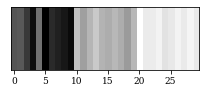

In [24]:
# Importance by input features
imptz,muImptz=estimateImportance(weight0)
print(muImptz)
repeat_n=(muImptz.shape[1]//3) ## for better visualization
fig,ax=plt.subplots(1,1, figsize=[fig_dims[0],fig_dims[1]])
plt.set_cmap('Greys')

plt.imshow(muImptz[[0]*repeat_n,0:])
ax.axes.yaxis.set_visible(False)
plt.savefig('importance.pdf',format='pdf',bbox_inches="tight")


In [25]:
# Find the top 2 most important features
idxByImptz=muImptz.argsort(descending=True)[0]
idxByImptz[0:2]

tensor([5, 9])